In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import numpy.ma as ma

import matplotlib.ticker as ticker

from mpl_toolkits.axes_grid1 import make_axes_locatable #for subplot colorbars
from matplotlib.pyplot import cm


# configure plotting
%config InlineBackend.rc = {'figure.dpi': 300, 'savefig.dpi': 300, \
                            'figure.figsize': (6, 6 / 1.6), 'font.size': 8, \
                            'figure.facecolor': (1, 1, 1, 0),'font.sans-serif':'Latin Modern Math'}

from matplotlib import rc
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)


%matplotlib inline

/home/nakul/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Spatial maps

In [2]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as ticker

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

cmap = 'inferno_r'

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [7]:
def spatial_maps(a,mask):
    
    a[a <= 0] = 1e-32
    l = 3.3 * 100000
    c = ((8*np.pi)*(np.sqrt(2/5))*l)/633
    
    mask = mask
    masked_map = ma.masked_array(a, mask=mask)
    masked_map = -(np.log(masked_map)/c) 
    
    return masked_map

In [8]:
def G_maps(a,mask):
    
    a[a <= 0] = 1e-32

    mask = mask
    masked_map = ma.masked_array(a, mask=mask)
    
    return masked_map

# Loading data

In [45]:
os.chdir(
    '/media/nakul/Seagate Portable Drive/Data/DWS_Creep/DWS_Correlation_Outputs/Boundaries/Flat_Rough/02_14_2022/02_14_2022_C'
)

data = np.load('FlatRough_02_14_2022_C_Gmaps.npz')
correlation_maps_cumulative = data['data1']
correlation_maps_instantaneous = data['data2']
mask = data['data3']

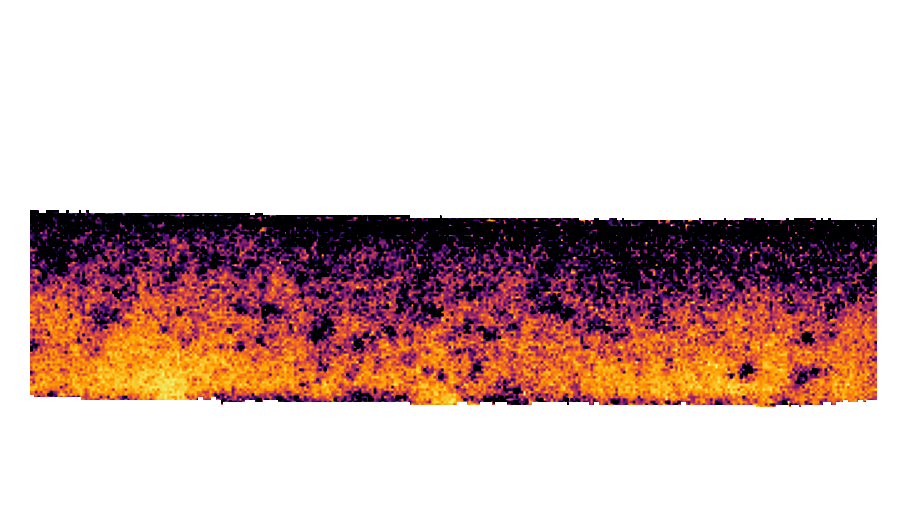

In [28]:
strain_map = spatial_maps(correlation_maps_cumulative[9][99], mask)

cmap = 'inferno_r'
vmin = 1e-7
vmax = 5e-5

fig = plt.figure(figsize=(6, 2))
ax = plt.subplot(111)

im = ax.imshow(strain_map, vmin=vmin, vmax=vmax, cmap=cmap)
ax.axis('off')
ax.set_xticks([])
ax.set_yticks([])

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
# fig.colorbar(im,
#              cax=cax,
#              orientation='vertical',
#              format=ticker.FuncFormatter(fmt))
# # cax.tick_params(labelsize=15)
# cax.set_title(r'$\dot{\epsilon}[s^{-1}]$', fontsize=14)

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.savefig(
#     '/home/nakul/Documents/NaturalPhilosophy/Presentations/PhD_Defense/Images/boundaries/FlatRough_02_11_2022_C_tw9_tau99.png',
#     bbox_inches='tight')

# Cropping and rotating

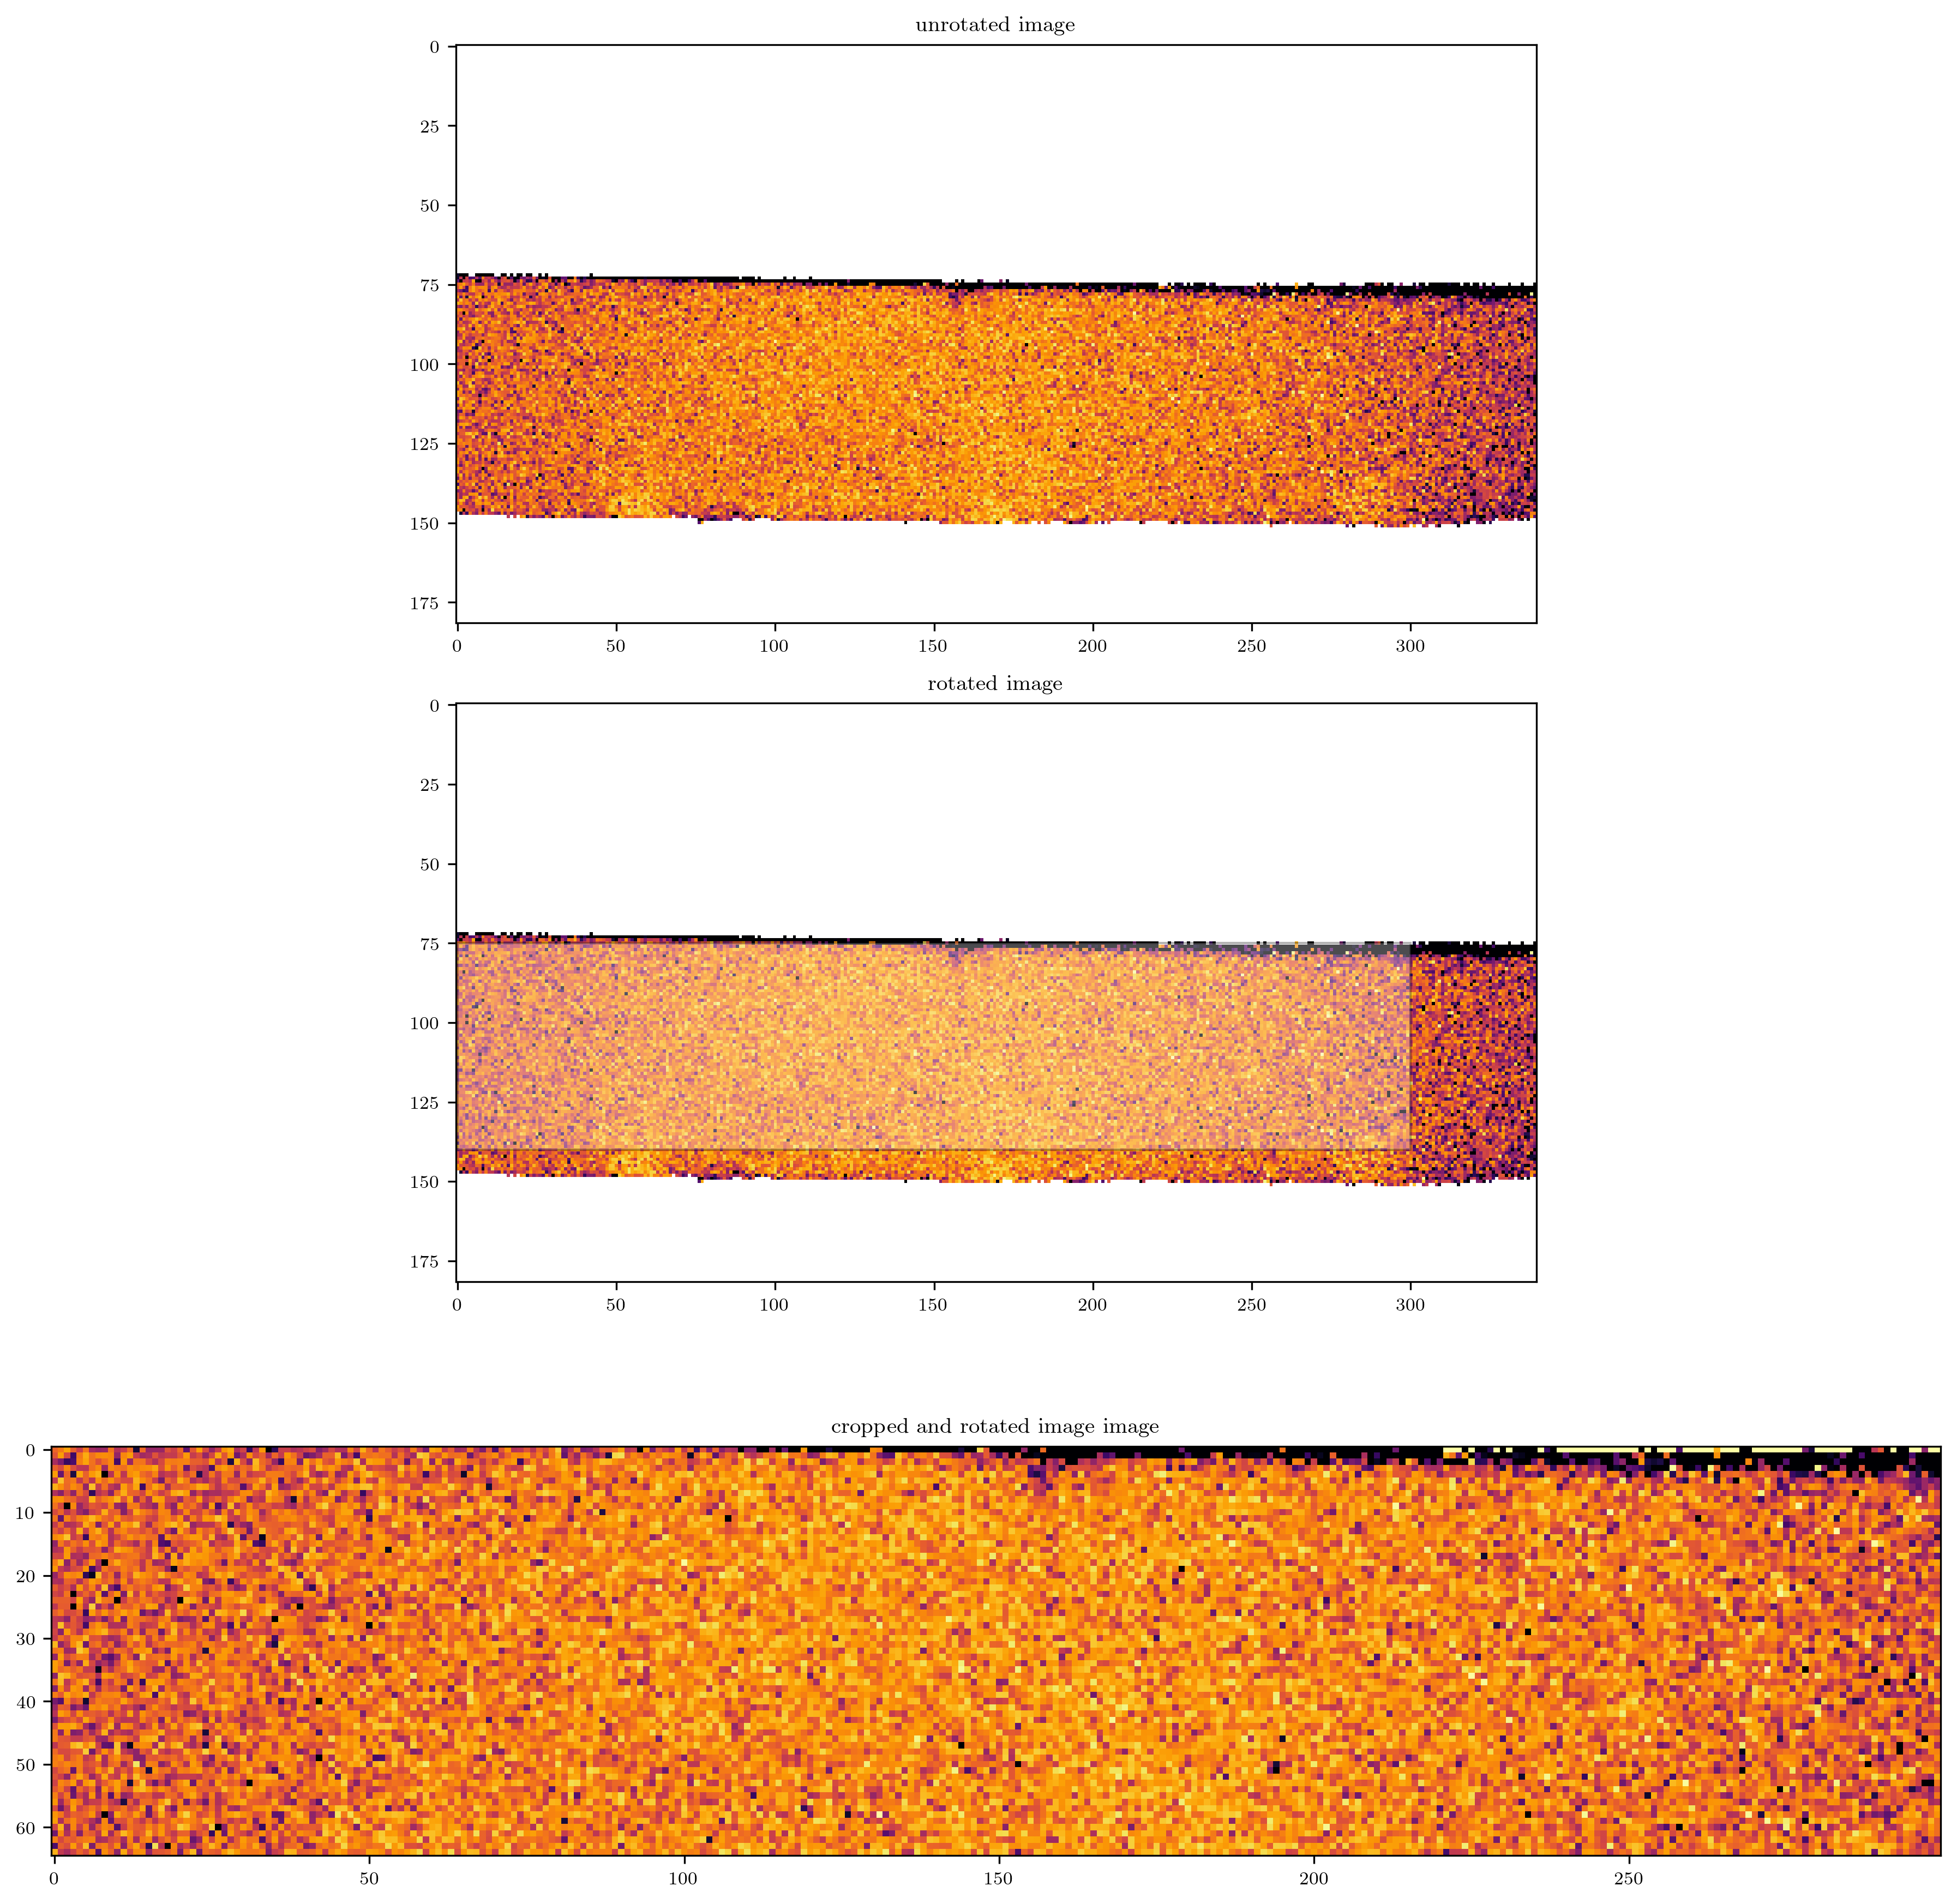

In [42]:
from skimage import transform

l = 3.3 * 100000
c = ((8*np.pi)*(np.sqrt(2/5))*l)/633



img = spatial_maps(correlation_maps_cumulative[1][1], mask)

x_min = 0
x_max = 300
y_min = 75
y_max = 140

rotation_angle = 0

# this is the depth, in metapixels
z = np.arange(.5,(y_max-y_min),1)
#depth in pixels
z = z*6
#depth in meters
z = z*5.39e-5

rotated_test = transform.rotate(img,rotation_angle,preserve_range = True,resize = True)
rotated_mask = transform.rotate(mask,rotation_angle,preserve_range = True,resize = True)
rotated_masked_image = ma.masked_array(rotated_test,mask = rotated_mask) 

roi_verts = [[y_max,x_max],[y_min,x_max],[y_min, x_min], [y_max, x_min]]
roi_verts.append(roi_verts[0])
x_roi, y_roi = zip(*roi_verts) 

cropped_rows = rotated_test[y_min:y_max,x_min:x_max].shape[0]

###################################################################################
fig = plt.figure(figsize=(12,12))


ax1 = plt.subplot(311)
ax1.imshow(img,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
# ax1.set_xlim([0,180])
# ax1.axis('off')
ax1.set_title('unrotated image')

ax2 = plt.subplot(312)
ax2.imshow(rotated_masked_image,vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax2.fill(y_roi,x_roi,'w',alpha = .3,edgecolor = 'k') 
# ax2.axis('scaled')
ax2.set_title('rotated image')
# ax2.axis('off')

ax3 = plt.subplot(313)
ax3.imshow(rotated_test[y_min:y_max,x_min:x_max],vmin = 1e-7,vmax = 1e-5,cmap = 'inferno_r')
ax3.set_title('cropped and rotated image image')
# ax3.axis('off')

plt.tight_layout()

map_shape = rotated_test[y_min:y_max,x_min:x_max].shape

# Spatial Correlation

In [43]:
def autocorrelate(z_tile):
    #subtracting the mean 
    z_tile = z_tile-np.mean(z_tile)
    #take the fft
    z_fft   = 1/np.shape(z_tile)[1]/np.shape(z_tile)[0]*np.fft.fft2(z_tile)
    z_fft_r = (z_fft.real**2+z_fft.imag**2)**0.5
    
    #shift high modes to the middle, erase the lowest modes
    z_fft_s = np.fft.fftshift(z_fft_r)
    
    #get autocorrelation of the topo data via the inverse of the fft
    z_rft_s = np.fft.fftshift(np.fft.ifft2((z_fft)*np.conj((z_fft)))).real*np.shape(z_tile)[1]*np.shape(z_tile)[0]
    z_rft_s = z_rft_s/np.nanvar(z_tile)

    x = np.arange(np.shape(z_tile)[0])-np.shape(z_tile)[0]/2
    y = np.arange(np.shape(z_tile)[1])-np.shape(z_tile)[1]/2
    X,Y = np.meshgrid(x,y) 
    
    return z_rft_s#,X,Y

In [44]:
strain_map = rotated_test[y_min:y_max,x_min:x_max]

In [45]:
test = autocorrelate(strain_map)

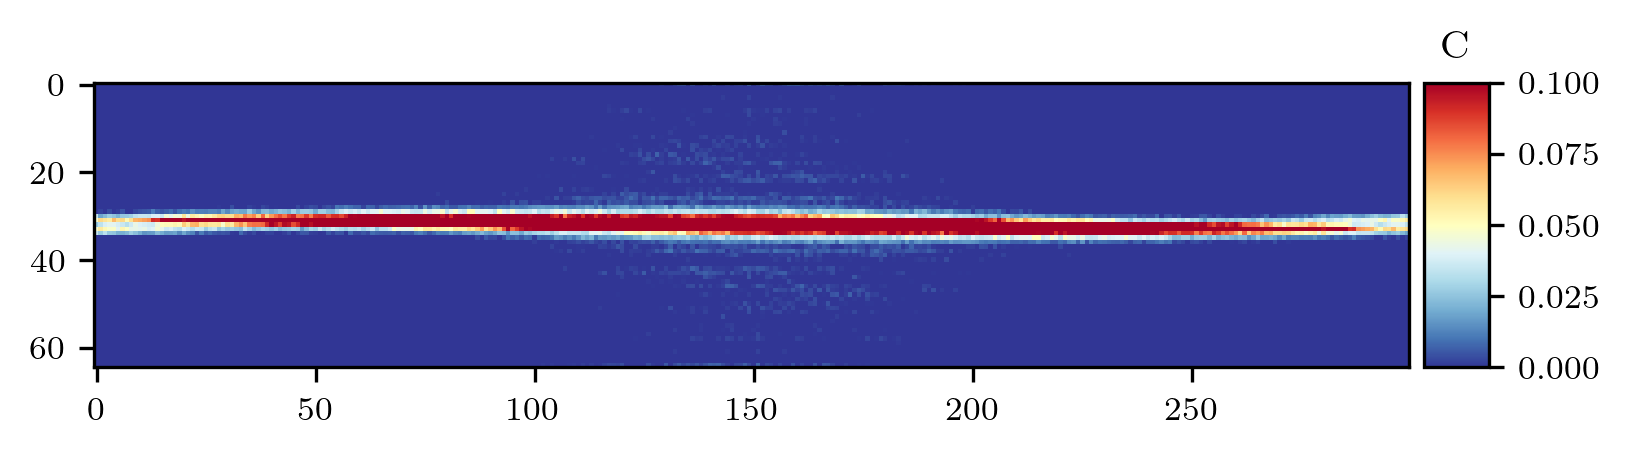

In [46]:
# fig = plt.figure(figsize=(4,4))

vmin = 0
vmax = .1
cmap = 'RdYlBu_r'

ax = plt.subplot(111)

# im = ax.contour(test, vmin=0, vmax=.7, cmap=cmap)
# im = ax.contourf(test, vmin=0, vmax=.7, cmap=cmap)

im = ax.imshow(test, vmin=vmin, vmax=vmax, cmap=cmap)

# ax.set_aspect('.55')

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
# cax.tick_params(labelsize=15)
cax.set_title('C')

# ax.set_aspect(.5)

fig.tight_layout()

# plt.savefig('/home/nakul/Documents/Python Scripts/MaterialsBoundaries/Materials/PaperFigures/Maps_Boundaries/correlation_test.svg', bbox_inches='tight')

# Movies

In [40]:
# dark mode plotting
plt.style.use('dark_background')

In [47]:
fig = plt.figure(figsize=(6, 2))

from mpl_toolkits.axes_grid1 import make_axes_locatable
l = 3.3 * 100000
c = ((8 * np.pi) * (np.sqrt(2 / 5)) * l) / 633
n = 0
time = np.arange(0, 1000, 1)

for i in range(99):

    ########################################################################################
    fig = plt.figure(figsize=(6, 2))
    ax1 = plt.subplot(111)
    ########################################################################################
    frame = correlation_maps_cumulative[0][i]
    masked_map = ma.masked_array(frame, mask=mask)
    masked_map[masked_map <= 0] == 1e-32
    masked_map = -(np.log(masked_map) / c)
    im1 = ax1.imshow(masked_map, vmin=1e-7, vmax=5e-5, cmap='inferno_r')
    cmap = plt.cm.gray
    cmap.set_bad('white', 1.)
    ########################################################################################
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1,
                 cax=cax,
                 orientation='vertical',
                 format=ticker.FuncFormatter(fmt))
    # cax.tick_params(labelsize=15)
    cax.set_title(r'$\epsilon$', fontsize=14)
    ax1.axis('off')
    ########################################################################################
    fig.tight_layout()

    plt.savefig(
        "/home/nakul/Documents/NaturalPhilosophy/Presentations/PhD_Defense/Videos/rough/cumulative/tw0/img_"
        + str(n) + ".png",
        format="PNG")
    plt.clf()
    n += 1

/tmp/ipykernel_19253/1149912001.py:21: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("gray").copy()
  cmap.set_bad('white', 1.)
/tmp/ipykernel_19253/1149912001.py:18: RuntimeWarning: divide by zero encountered in log
  masked_map = -(np.log(masked_map) / c)
/tmp/ipykernel_19253/1149912001.py:18: RuntimeWarning: invalid value encountered in log
  masked_map = -(np.log(masked_map) / c)
/tmp/ipykernel_19253/1149912001.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(6, 2))
/tmp/ipykernel_19253/11

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>

<Figure size 1800x600 with 0 Axes>